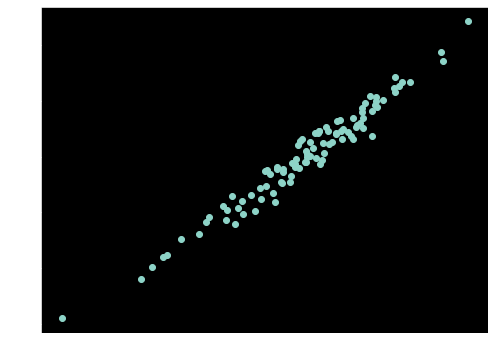

[[[    80]
  [  1251]]

 [[  1251]
  [317481]]]


In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
import tenseal as ts

plt.style.use("dark_background")

# Data generation and preparation
X, y = datasets.make_regression(n_samples=100, n_features=1, noise=20, random_state=1234)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

X_train = np.round(X_train, 3)
y_train = np.round(y_train, 3)
X_test = np.round(X_test, 3)
y_test = np.round(y_test, 3)

X = np.round(X, 3)
y = np.round(y, 3)

fig=plt.figure(figsize=(8,6))
plt.scatter(X[:,0],y)
plt.show()

# Scale data for encryption
X_train = X_train * 1000
y_train = y_train * 1000

X_train_augmented = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_train_T = X_train_augmented.T

# TenSEAL context initialization
context = ts.context(ts.SCHEME_TYPE.BFV, poly_modulus_degree=8192, plain_modulus=1032193, coeff_mod_bit_sizes=[40, 21, 21, 21, 21, 21, 21, 40])
context.generate_galois_keys()
context.global_scale = 2**21

# Encrypt training data
enc_X_train = [ts.bfv_vector(context, col) for col in X_train_T]
enc_y_train = ts.bfv_vector(context, y_train)

# Homomorphic computation of X^T * X
XTX = []
for i in enc_X_train:
    row_in = []
    for j in enc_X_train:
        p = i.dot(j)
        row_in.append(p)
    XTX.append(row_in)

# Homomorphic computation of X^T * y
XTY = [i.dot(enc_y_train) for i in enc_X_train]

# Decrypt X^T * X
XTX_dec = []
for row in XTX:
    row_dec = [elem.decrypt() for elem in row]
    XTX_dec.append(row_dec)

XTX_dec_1 = np.array(XTX_dec)

# Display the decrypted X^T * X
print(XTX_dec_1)

In [ ]:
XTY